In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
//hide this

<IPython.core.display.Javascript object>

In [2]:
#  hide this

%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from helper_functions import *

set_notebook_preferences()

## Visualising Bayesian linear regression: Online learning

We have introduced the [Bayesian approach to regression](regression_bayesian.ipynb).

### Incremental Updates

Until now we have been considering the whole dataset in one go. In this section we will be exploring how each point of in the dataset affects our knowledge about the model. This will expand our intuition about the bayesian approach and also show how we may go about *online learning* $-$ that is learning where the datapoints are gradually made available in a sequence. Online learning would for example be useful for scenarios such as weather prediction, where one can use each day's new data to improve the weather model.

Consider this scenario: we start off with a prior $p(\mathbf{w})$ and the data is made available on a point-by-point basis, in $(x_n, y_n)$ pairs. After observing one point, we can use Bayes' rule to evaluate the posterior, and use this to calculate the predictive:

$$
p(\mathbf{w}| y_1, x_1) \propto p(y_1| x_1, \mathbf{w}, \sigma^2)p(\mathbf{w})
$$

$$
p(y^* | x^*, y_1, x_1) = \int p(y^* | x^*, \mathbf{w}) p(\mathbf{w}|y_1, x_1) d\mathbf{w}
$$

When $(x_2, y_2)$ becomes available, we can use it to update our model. The weight distribution prior to seeing $(x_2, y_2)$ is $p(\mathbf{w}|y_1, x_1)$, reflecting the knowledge gained from $(x_1, y_1)$. Applying Bayes' rule again:

$$
p(\mathbf{w}| \{y_{n}, x_{n}\}^2_{n = 1}) \propto p(y_2| x_2, \mathbf{w}, \sigma^2)p(\mathbf{w}|y_1, x_1)
$$

$$
p(y^* | x^*, \{y_{n}, x_{n}\}^2_{n = 1}) = \int p(y^* | x^*, \mathbf{w}) p(\mathbf{w}|\{y_{n}, x_{n}\}^2_{n = 1}) d\mathbf{w}
$$

And in general after observing $N$ datapoints:

$$
p(\mathbf{w}| \{y_{n}, x_{n}\}^{N}_{n = 1}) \propto p(y_{N}| x_{N}, \mathbf{w}, \sigma^2)p(\mathbf{w}|y_{N-1}, x_{N-1})
$$

$$
p(y^* | x^*, \{y_{n}, x_{n}\}^{N}_{n = 1}) = \int p(y^* | x^*, \mathbf{w}) p(\mathbf{w}|\{y_{n}, x_{n}\}^N_{n = 1}) d\mathbf{w}
$$

**Note how the posterior of the $\mathbf{(N-1)^{th}}$ step becomes the prior for the $\mathbf{N^{th}}$ step.** This reflects the gradual increase in our knowledge about $\mathbf{w}$. It should be pointed out that for arbitrary distributions we must calculate the constant of proportionality for the posterior, or equivalently normalize $p(y^* | x^*, \{y_{n}, x_{n}\}^{N}_{n = 1})$ at the end to get a valid probability distribution $-$ this integral may be challenging and will often need to be approximated. Fortunately, in the special case of gaussian likelihoods with a conjugate prior we don't need to bother with this since the normalization constant is determined by the covariance matrix which we already know how to find.

The last outstanding point regarding this process is the noise level \\(\sigma\\). When learning the whole dataset at once, we used the \\(\sigma_{ML}\\) which maximised the likelihood as an estimate for the noise magnitude. It is possible to follow a fully Bayesian approach including a prior over \\(\sigma\\), but this is too involved for our purposes, so we will stick with the estimate \\(\sigma_{ML}\\) which maximises the likelihood of the observed points. For the first step where no points have yet been observed \\(\sigma_{ML}\\) would be \\(0\\) giving an infinitely sharp gaussian. To prevent this problem, which would otherwise constrain subsequent posteriors to be infinitely sharp as well, we will use an arbitrary noise level of \\(1\\).

Let's implement this method for the linear dataset since this has $2$ weights which we can easily visualise with a contour plot $-$ unlike the non-linear example which has several weights which we can't easily visualise in one go. At each step, will also draw $3$ weight samples from the posterior and plot the corresponding lines in data-space.

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


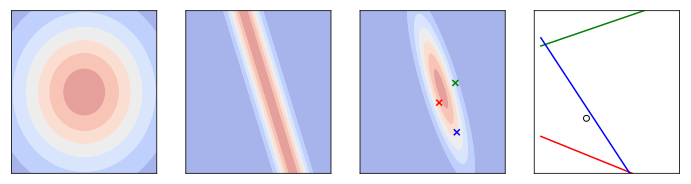

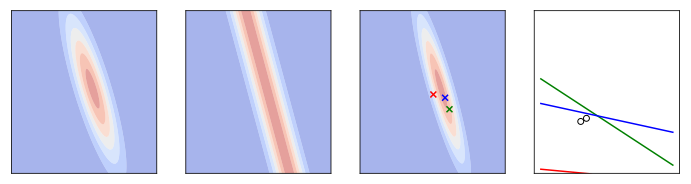

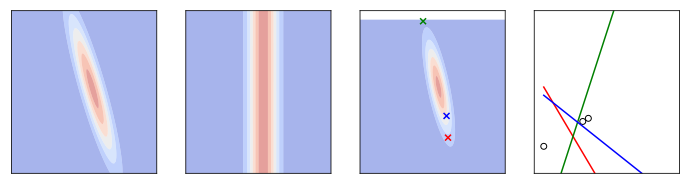

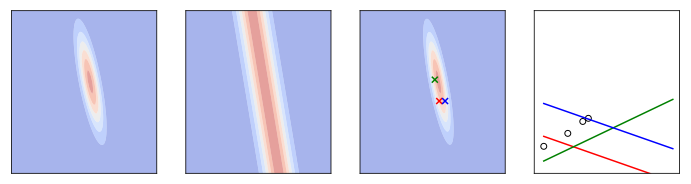

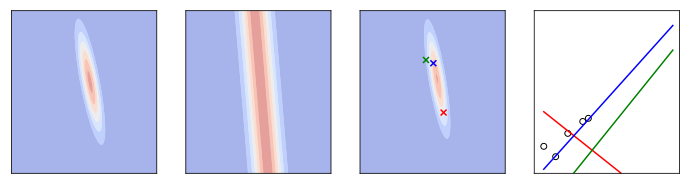

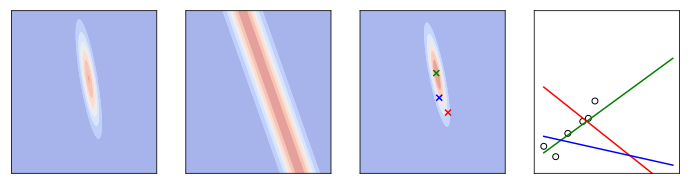

In [4]:
x_lin = np.load('reg_lin_x.npy')  
y_lin = np.load('reg_lin_y.npy') # loading the linear regression dataset into numpy arrays

w1_range, w2_range = np.linspace(-5, 5, 100), np.linspace(-5, 5, 100) # specify the range of weights to be visualised
w1, w2 = np.meshgrid(w1_range, w2_range) # returns two 2d arrays with the values of w1_range and w2_range (see docs!)
grid = np.stack([w1, w2], axis = 2) # stack the two grids together to do aritmetic elegantly later

lamda = 10
no_points = 5 # do the algorithm for 3 sequential observations
prior = None # start with a null prior
noise = 1

colours = ['red', 'green', 'blue']
x_ = np.linspace(0, 1, 100)

for n in range(no_points + 1):

    X = np.array([[x_lin[n] ** d for d in range(0, 2)]]) # X contains a single point (x[n]) for online learning
    
    if n == 0:
        prior_Q = np.sum(grid.dot(np.eye(2) / lamda) * grid, axis = 2) # quadratic form of prior (goes in the exponent)
        prior = np.exp(-1 / 2 * prior_Q) # exponentiate quadratic form to get the prior
        
    lik_Q = np.sum((y_lin[n] - grid.dot(X.T)) ** 2/0.5, axis = 2) # quadratic form of likelihood of (x[n], y[n]) point
    lik = np.exp(-1 / 2 * lik_Q) # exponentiate quadratic form to get the likelihood of the new point
    
    post = prior * lik # posterior is prior*lik by Bayes' rule

    plt.figure(figsize = (12, 3)) # add new figure to plot this step
    for i, values in enumerate([prior, lik, post]):
        plt.subplot(1, 4, i + 1)
        plt.contourf(w1_range, w2_range, values, cmap = 'coolwarm', alpha = 0.5) # plot prior after n points
        remove_axes()
    
    for i in range(3):
        plt.subplot(143)
        w1, w2 = sample_weights_from(w2_range, w1_range, post)
        plt.scatter(w1, w2, marker = 'x', color = colours[i])
        
        plt.subplot(144)
        plt.plot(x_, w1 + w2 * x_, color = colours[i])
        remove_axes()
    
    plt.subplot(144)
    plt.scatter(x_lin[:n + 1], y_lin[:n + 1], marker = 'o', facecolor = 'None', edgecolor = 'black')
    plt.ylim([0, 2])
    
    prior = post.copy() # set prior of the next step to be the posterior of the current step

    plt.show()

The first plot in the first row we see the prior before any data has been observed. After one datapoint is observed, our certainty about the values of the weights is improved: the likelihood (second plot, first row) multiplied by the prior gives a narrowed posterior (third plot, first row). Three independent weight samples are drawn (red, green and blue crosses) from the posterior giving the corresponding linear trendlines in data space (data as black crosses). In the next step **the prior is the posterior of the previous step**, i.e. $3^{rd}$ plot of $n^{th}$ row is the same as the $1^{st}$ plot of the $(n+1)^{th}$ row. Note that as more datapoints are added the posterior narrows down, and the weights are constrained to a progressively narrower area. This is reflected in the data space where the red/green/blue lines are also progressively constrained.

Having covered bayesian linear regression, you should now understand:

1. Why finding the $\mathbf{w}$ using MAP with a gaussian likelihood and prior is equivalent to doing least-squares with $\mathbf{L2}$ regularization
2. How to take a bayesian inference approach to regression problems, including how to calculate $\mathbb{E}$(y) and Var(y) for your fitted model.
3. How the model can be adapted to dynamically change with new data points for online learning
